In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import math
import networkx as nx
from tqdm import tqdm
from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid
from sklearn.decomposition import NMF
from tigramite import plotting as tp
import json

from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, SpectralClustering


In [3]:
from expbasics.network_binary import train_network as train_network_binary
from expbasics.network import train_network as train_network, accuracy_per_class
from expbasics.biased_dsprites_dataset import get_test_dataset, get_biased_loader, BiasedDSpritesDataset
from expbasics.crp_hierarchies import sample_from_categories
from expbasics.network import train_network, accuracy_per_class
from expbasics.ground_truth_measures import GroundTruthMeasures
from expbasics.crp_attribution import CRPAttribution, vis_simple

%reload_ext autoreload
%autoreload 2

In [4]:
unb_short, unbiased_ds, test_loader = get_test_dataset(split=0.1)

{0: Counter({False: 191196, True: 54564}), 1: Counter({True: 191369, False: 54391})}
cpu
../clustermodels/nmf_b0i6_s0i5_l0i016.pickle


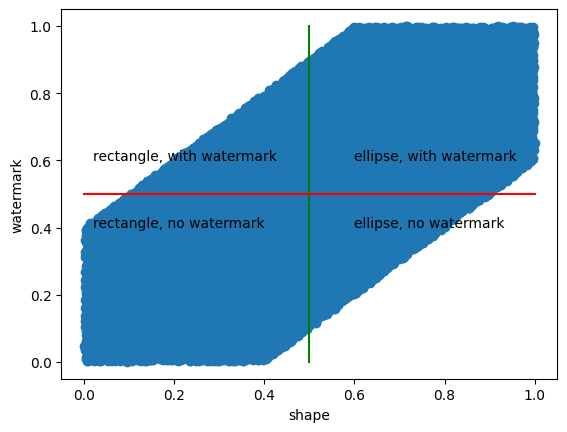

In [5]:
BIAS = 0.6
STRENGTH = 0.5
BATCH_SIZE = 128
LR = 0.016
NAME = "../clustermodels/nmf"

train_loader = get_biased_loader(BIAS, 0.5, batch_size=BATCH_SIZE, verbose=True)
model = train_network(
    train_loader,
    BIAS,
    STRENGTH,
    NAME,
    BATCH_SIZE,
    load=True,
    retrain=False,
    learning_rate=LR,
    epochs=4
)


In [6]:
gm = GroundTruthMeasures()
#neuron_flips = gm.compute_multiple_neuron_flips(model, "simple")
#ols_flips = gm.ols_values(model)
#r2_vals = gm.ordinary_least_squares(ols_flips)
#ols_flips, r2_vals

In [7]:
crp_attribution = CRPAttribution(model, unbiased_ds, "nmf", STRENGTH, BIAS)

# composite = EpsilonPlusFlat()
# cc = ChannelConcept()
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# tdev = torch.device(device)
# layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
# gm = GroundTruthMeasures(binary=True)
# neuron_flips = gm.compute_multiple_neuron_flips(model, "bbox")
# image = gm.load_image(300000, True)

In [8]:
ACTIVATIONS = False
FEATURE = "linear_layers.1"
return_nodes = [FEATURE]
m_names = ["tsne", "iso", "pca", "nmf"]
tsne = TSNE(n_components=2, perplexity=10)
iso = Isomap(n_components=2)
pca = PCA(n_components=2)
nmf = NMF(4, max_iter=10000)
methods = [tsne, iso, pca, nmf]
model2 = create_feature_extractor(model, return_nodes=return_nodes)

In [9]:
n_samples = 1000
vector = torch.zeros((n_samples, 6))
#activationvector = torch.zeros((n_samples, 6))
predictions = []
labels = []
watermarks = []
idx = np.round(np.linspace(0, 491519, n_samples)).astype(int)
for i in range(n_samples):
    img_idx = idx[i]
    img = gm.load_image(img_idx,False)
    #layer_features = model2(img)
    att, predict, label, wm = crp_attribution.relevances(
        img_idx, activations=ACTIVATIONS
    )
    predictions.append(int(predict))
    labels.append(label)
    watermarks.append(wm)
    vector[i] = att
    #activationvector[i] = layer_features[FEATURE]
watermarks = np.array(watermarks)
predictions = np.array(predictions)
labels = np.array(labels)

torch.Size([245, 2])
torch.Size([3, 2])
torch.Size([241, 2])
torch.Size([11, 2])
torch.Size([1, 2])
torch.Size([248, 2])
torch.Size([251, 2])


Text(0.5, 1.0, 'Bias: 0.6, Relevance: True, Method: Maximum Indices')

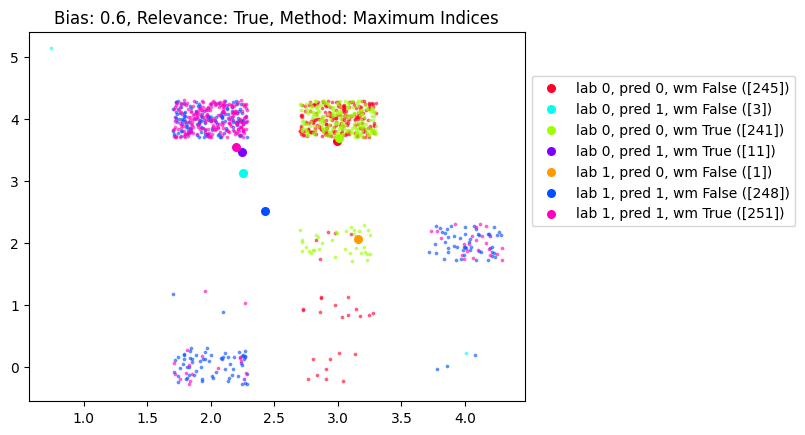

In [21]:
maxs = torch.topk(vector, 2, dim=1)
res = maxs.indices
METHOD = 2
ALPHA = 0.5
colors = mpl.cm.gist_rainbow(np.linspace(0, 1, 8))  # gist_ncar


def ft(lab, wm, pred=None):
    d = np.logical_and(watermarks == wm, labels == lab)
    if pred is not None:
        d = np.logical_and(d, predictions == pred)
    if res[d, 0].shape[0] > 0:
        points = res[d,:] + np.random.uniform(-0.3, 0.3, res[d,:].shape)
        print(res[d,:].shape)
        plt.scatter(
            points[:,0],
            points[:,1],
            s=3,
            color=colors[lab + 2 * wm + 4 * pred],
            alpha=ALPHA,
        )
        meanp = torch.mean(points, dim=0)
        plt.scatter(
            meanp[0],
            meanp[1],
            s=30,
            color=colors[lab + 2 * wm + 4 * pred],
            alpha=1,
            label=f"lab {lab}, pred {pred}, wm {wm == 1} ({[res[d,0].shape[0]]})",
        )


for lab in [0, 1]:
    for wm in [0, 1]:
        for pred in [0, 1]:
            ft(lab, wm, pred)

plt.legend(bbox_to_anchor=(1, 0.9))
plt.title(f"Bias: {BIAS}, Relevance: {not ACTIVATIONS}, Method: Maximum Indices")
# centroids

lab 0, pred 1, wm False, (3), median: [0.850457 0.343203]
lab 0, pred 0, wm False, (245), median: [-0.63064164 -0.01306895]
lab 0, pred 1, wm True, (11), median: [ 0.7581209  -0.23546371]
lab 0, pred 0, wm True, (241), median: [-0.63064164 -0.01306895]
lab 1, pred 1, wm False, (248), median: [0.55490243 0.06360334]
lab 1, pred 0, wm False, (1), median: [-0.6305801  -0.01308866]
lab 1, pred 1, wm True, (251), median: [0.59441406 0.04690709]


Text(0.5, 1.0, 'Bias: 0.6, Activations: False, Method: pca')

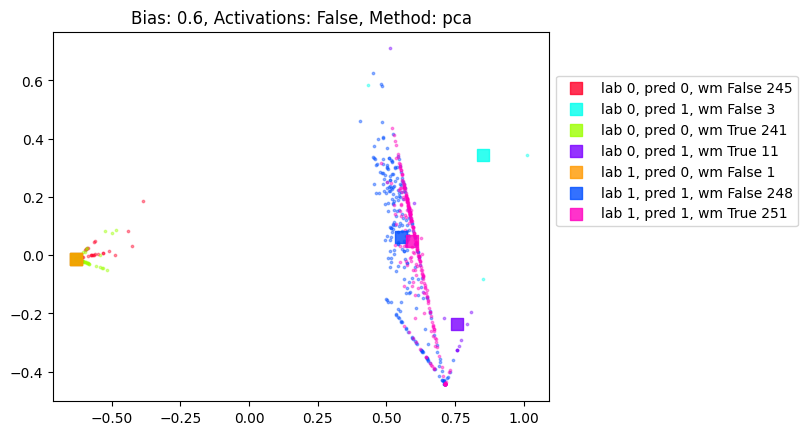

In [22]:
METHOD = 2
#nmf_res = methods[METHOD].fit_transform(vector.numpy())
#res = pca.fit_transform(nmf_res)
res = methods[METHOD].fit_transform(vector.numpy())
ALPHA = 0.4

centroids = np.zeros((8, 2))
counts = np.zeros((8), dtype=int)

colors = mpl.cm.gist_rainbow(np.linspace(0, 1, 8))  # gist_ncar


def ft(lab, wm, pred=None):
    d = np.logical_and(watermarks == wm, labels == lab)
    if pred is not None:
        d = np.logical_and(d, predictions == pred)
    if res[d, 0].shape[0] > 0:
        print(
            f"lab {lab}, pred {pred}, wm {wm == 1}, ({res[d,0].shape[0]}), median: {np.median(res[d], 0)}"
        )
        plt.scatter(
            res[d, 0],
            res[d, 1],
            s=3,
            color=colors[lab + 2 * wm + 4 * pred],
            alpha=ALPHA,
        )
        centroids[lab + 2 * wm + 4 * pred] = np.median(res[d], axis=0)
        counts[lab + 2 * wm + 4 * pred] = res[d, 0].shape[0]
    else:
        centroids[lab + 2 * wm + 4 * pred] = np.array([np.nan, np.nan])


ft(0, 0, 1)
ft(0, 0, 0)
ft(0, 1, 1)
ft(0, 1, 0)

ft(1, 0, 1)
ft(1, 0, 0)
ft(1, 1, 1)
ft(1, 1, 0)


for lab in [0, 1]:
    for wm in [0, 1]:
        for pred in [0, 1]:
            if counts[lab + 2 * wm + 4 * pred] > 0:
                plt.scatter(
                    centroids[lab + 2 * wm + 4 * pred, 0],
                    centroids[lab + 2 * wm + 4 * pred, 1],
                    color=colors[lab + 2 * wm + 4 * pred],
                    marker="s",
                    s=70,
                    label=f"lab {lab}, pred {pred}, wm {wm == 1} {counts[lab + 2*wm + 4* pred]}",
                    alpha=0.8
                )

plt.legend(bbox_to_anchor=(1, 0.9))
plt.title(f"Bias: {BIAS}, Activations: {ACTIVATIONS}, Method: {m_names[METHOD]}")
# centroids

lab 0, wm False, (242), MEAN: [-0.59491915 -0.0086474 ]
lab 0, wm True, (258), MEAN: [-0.56760406 -0.07685098]
lab 1, wm False, (254), MEAN: [0.4852414 0.5518079]
lab 1, wm True, (246), MEAN: [ 0.6795192 -0.4806462]


Text(0.5, 1.0, 'Bias: 0.7, Activations: False, Method: pca')

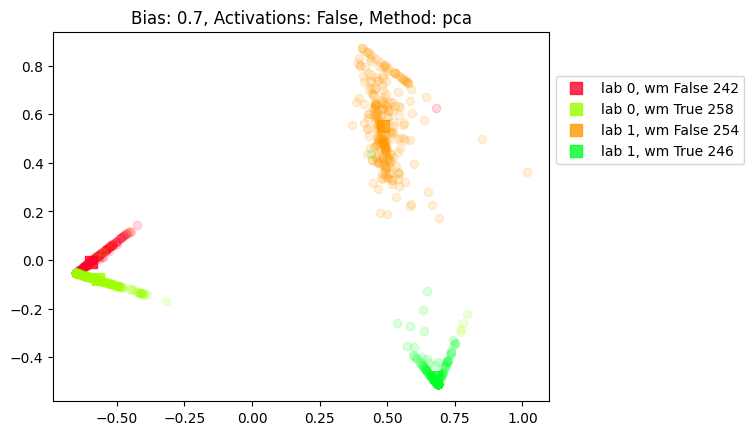

In [123]:
METHOD = 2
res = methods[METHOD].fit_transform(vector.numpy())
ALPHA = 0.15

centroids = np.zeros((4, 2))
counts = np.zeros((4), dtype=int)

colors = mpl.cm.gist_rainbow(np.linspace(0, 1, 8))  # gist_ncar


def ft(lab, wm):
    d = np.logical_and(watermarks == wm, labels == lab)
    if res[d, 0].shape[0] > 0:
        print(
            f"lab {lab}, wm {wm == 1}, ({res[d,0].shape[0]}), MEAN: {np.mean(res[d], 0)}"
        )
        plt.scatter(
            res[d, 0],
            res[d, 1],
            color=colors[lab + 2 * wm],
            alpha=ALPHA,
        )
        centroids[lab + 2 * wm] = np.mean(res[d], axis=0)
        counts[lab + 2 * wm] = res[d, 0].shape[0]
    else:
        centroids[lab + 2 * wm] = np.array([np.nan, np.nan])


ft(0, 0)
ft(0, 1)
ft(1, 0)
ft(1, 1)


for lab in [0, 1]:
    for wm in [0, 1]:
        if counts[lab + 2 * wm] > 0:
            plt.scatter(
                centroids[lab + 2 * wm, 0],
                centroids[lab + 2 * wm, 1],
                color=colors[lab + 2 * wm],
                marker="s",
                s=70,
                label=f"lab {lab}, wm {wm == 1} {counts[lab + 2*wm]}",
                alpha=0.8,
            )

plt.legend(bbox_to_anchor=(1, 0.9))
plt.title(f"Bias: {BIAS}, Activations: {ACTIVATIONS}, Method: {m_names[METHOD]}")
# centroids

In [29]:
with open("outputs/tsne_experiment.json", "r") as f: 
    analysis_data = json.load(f)
    
data = sorted(analysis_data.values(), key=lambda x: x["bias"])
experiment = [a["tsne_experiment"] for a in data]
tsne_experiment_no_prediction =  [a["tsne_experiment_no_prediction"] for a in data]
biases = [a["bias"] for a in  data]

In [64]:
with open("outputs/combined_accuracies.json", "r") as f:
    analysis_data = json.load(f)
    alldata = sorted(analysis_data.values(), key=lambda x: x["bias"])
    biases = [
        a["bias"] for a in list(filter(lambda x: x["learning_rate"] == 0.009, alldata))
    ]

In [67]:
ind = 1

datas = np.zeros((4, 101))
datas[0] = [
    a["train_accuracy"][ind]
    for a in list(filter(lambda x: x["learning_rate"] == 0.001, alldata))
]
datas[1] = [
    a["train_accuracy"][ind]
    for a in list(filter(lambda x: x["learning_rate"] == 0.005, alldata))
]
datas[2] = [
    a["train_accuracy"][ind]
    for a in list(filter(lambda x: x["learning_rate"] == 0.007, alldata))
]
datas[3] = [
    a["train_accuracy"][ind]
    for a in list(filter(lambda x: x["learning_rate"] == 0.009, alldata))
]
data = np.sum(datas, 0) / 4

Text(0.5, 0, 'Bias')

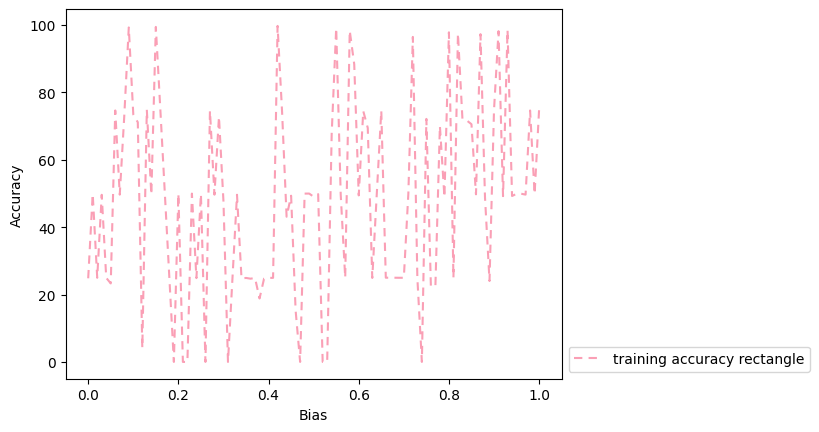

In [68]:
#data = list(filter(lambda x: x["learning_rate"] == 0.009, alldata))

rcol = ['#fa9fb5','#f768a1','#c51b8a','#7a0177']
ecol= ['#addd8e','#78c679','#31a354','#006837']
plt.plot(biases, data, c=rcol[0], label=f"training accuracy rectangle", linestyle=(0,(4,3)))
#plt.plot(biases, [a["train_accuracy"][0] for a in  data], c=rcol[0], label=f"training accuracy rectangle", linestyle=(0,(4,3)))
#plt.plot(biases, [a["all_wm_accuracy"][0] for a in  data], c=rcol[2], label=f"all watermark rectangle", linestyle="dashed")
#plt.plot(biases, [a["no_wm_accuracy"][0] for a in  data], c=rcol[3], label=f"no watermark rectangle", linestyle="dotted")
#plt.plot(biases, [a["train_accuracy"][1] for a in  data], c=ecol[0], label=f"training accuracy ellipse", linestyle=(0,(5,3)))
#plt.plot(biases, [a["train_accuracy"][2] for a in  data], c=ecol[2], label=f"training accuracy all", linestyle="dashed")
#plt.plot(biases, [a["all_wm_accuracy"][1] for a in  data], c=ecol[2], label=f"all watermark ellipse", linestyle="dashed")
#plt.plot(biases, [a["no_wm_accuracy"][1] for a in  data], c=ecol[3], label=f"no watermark ellipse", linestyle=(0,(1,1)))
plt.legend(loc="lower left", bbox_to_anchor=(1, 0))
plt.ylabel("Accuracy")
plt.xlabel("Bias")

In [30]:
labels = []
labels_no_pred = ["", "", "", ""]
for label in [0, 1]:
    for watermark in [0, 1]:
        labels_no_pred[label + 2 * watermark] = f"l:{label} w:{watermark}"
        for prediction in [0, 1]:
            labels.append(f"l:{label} w:{watermark} p:{prediction}")
means = [
    [np.array(a[i]) if i < len(a) else np.zeros(len(a[i])) for i in range(8)]
    for a in experiment  # pca_experiment
]

means_nopred = [[np.array(x) for x in a] for a in tsne_experiment_no_prediction]
labels_no_pred

['l:0 w:0', 'l:1 w:0', 'l:0 w:1', 'l:1 w:1']

Text(0.5, 1.0, 'Mean Euclidean Distance of Centroids')

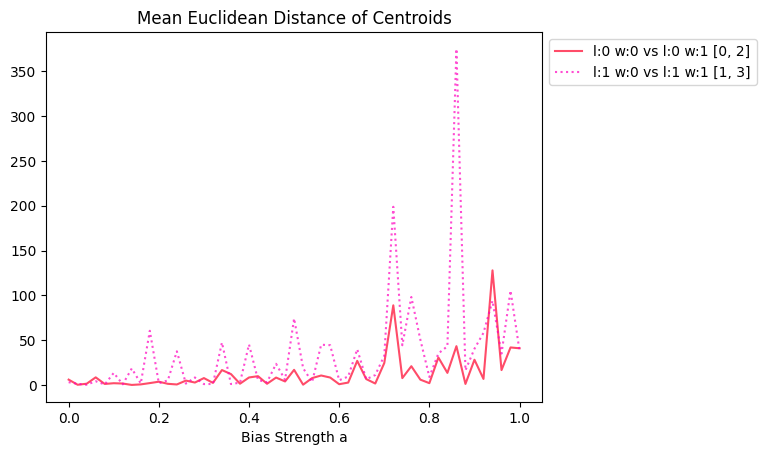

In [31]:
#combis = [[i, j] for i in range(4) for j in range(i + 1, 4)]
combis = [[0,2], [1,3]]
colors = mpl.cm.gist_rainbow(np.linspace(0, 1, len(combis)))  # gist_ncar
styles = ["solid", "dotted", "dashed", "dashdot"]

for x, c in enumerate(combis):
    diff = [np.linalg.norm((m[c[0]]) - (m[c[1]])) for m in means_nopred]
    plt.plot(
        biases,
        diff,
        label=f"{labels_no_pred[c[0]]} vs {labels_no_pred[c[1]]} {c}",
        color=colors[x],
        linestyle=styles[x % len(styles)],
        alpha=0.7
    )


plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Bias Strength a")
plt.title("Mean Euclidean Distance of Centroids")